## Sparse Parametric Control Policies

In this tutorial, we utilize twin-delayed deep deterministic policy gradient (TD3) for learning a control policy for the pendulum. We compare the standard TD3 algorithm, utlizing neural networks for approximating value function and policy, with the sparse polynomial TD3 we developed. The sparse polynomial TD3 relies on dictionary learning and L$_0$ regularization to learn a sparse and interpreable polynomial policy. 

In [16]:
import gymnasium as gym
from utils.replay_buffer import ExperienceReplayBuffer
import torch
import numpy as np
from utils.agents.td3 import TD3
from utils.agents.polyL0_td3 import TD3 as polyTD3

# Set seeds
seed = 23524
torch.manual_seed(seed)
np.random.seed(seed)

In [17]:
render = False

if render:
    env = gym.make('Pendulum-v1', g=9.81, render_mode="human")
else:
    env = gym.make('Pendulum-v1', g=9.81)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# set hyperparameters of the experiments
max_episodes = 250
max_steps = 200
warmup = 25

obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.shape[0]
max_act = 2
buf_dim = int(max_episodes*max_steps)

training_buffer = ExperienceReplayBuffer(state_dim=obs_dim, action_dim=act_dim, max_size=int(1e6))

h_dim = 256
tau = 0.005
eval_interval = 20
batch_size = 256
training_start = 50
training_iteration = 100

# TD3 agent
agent = TD3(state_dim=obs_dim, action_dim=act_dim, max_action=max_act, h_dim=h_dim, tau=tau, device=device)

degree = 3
scale = 1.0
reg_coeff = 0.05
droprate = 0.25
# polynomial TD3 agent
agent_poly = polyTD3(state_dim=obs_dim, action_dim=act_dim, max_action=max_act, degree_pi=degree, feature_scale=scale, reg_coeff=reg_coeff, droprate=droprate, tau=tau,device=device)

policy polynomial of order  3
with 20 coefficients
['1' 'x0' 'x1' 'x2' 'x0^2' 'x0 x1' 'x0 x2' 'x1^2' 'x1 x2' 'x2^2' 'x0^3'
 'x0^2 x1' 'x0^2 x2' 'x0 x1^2' 'x0 x1 x2' 'x0 x2^2' 'x1^3' 'x1^2 x2'
 'x1 x2^2' 'x2^3']
L0Dense(20 -> 1, droprate_init=0.25, lamba=1.0, temperature=0.6666666666666666, weight_decay=0.0, local_rep=False, bias=False)
L0Dense(20 -> 1, droprate_init=0.25, lamba=1.0, temperature=0.6666666666666666, weight_decay=0.0, local_rep=False, bias=False)


/home/nicolo/Documents/Sparsifying-Parametric-Models-with-L0/utils/l0_layer.py:51: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  init.kaiming_normal(self.weights, mode='fan_out')


Define train and evaluation functions.

In [18]:
def train_agent(agent, env, agent_type='td3'):
    training_rewards = []
    eval_rewards = []
    ep_reward = 0
    for episode in range(max_episodes):
        observation, info = env.reset()
        for steps in range(max_steps+1):
            if episode < warmup:
                action = env.action_space.sample()
            else:
                action = (agent.select_action(observation) + np.random.normal(0, max_act * 0.1, size=act_dim)).clip(-max_act, max_act)

            next_observation, reward, terminated, truncated, info = env.step(action)

            done = terminated or truncated

            training_buffer.add(observation, action, next_observation, reward, done)

            observation = next_observation

            ep_reward += reward

            if done:
                print("Training episode {} is done with reward {}".format(episode, ep_reward))
                training_rewards.append(ep_reward)
                ep_reward = 0.
                done = False
                if episode > training_start:
                    agent.train(training_buffer, iterations=training_iteration, batch_size=batch_size)

                if episode % eval_interval == 0 and episode > 0:
                    eval_rew = eval_agent(agent, agent_type=agent_type, ep=episode)
                    eval_rewards.append(eval_rew)
                break

    env.close()

    eval_rew = eval_agent(agent, agent_type=agent_type, ep=max_episodes+1)
    eval_rewards.append(eval_rew)

    return training_rewards, eval_rewards

def eval_agent(agent, eval_episodes=10,agent_type='td3', ep=1):

    eval_env = gym.make('Pendulum-v1', g=9.81)
    avg_reward = 0.
    ep_reward = 0.
    for episode in range(eval_episodes):

        observation, info = eval_env.reset()

        for steps in range(max_steps + 1):

            action = agent.select_action(observation)

            next_observation, reward, terminated, truncated, info = eval_env.step(action)

            done = terminated or truncated

            observation = next_observation

            ep_reward += reward

            if done:
                print("Evaluation episode {} is done with reward {}".format(episode, ep_reward))
                avg_reward += ep_reward
                ep_reward = 0
                done = False
                break

    eval_env.close()

    avg_reward = avg_reward / eval_episodes
    print("---------------------------------------")
    print(f"Evaluation over {eval_episodes} episodes: {avg_reward:.3f}")
    print("---------------------------------------")

    if agent_type == 'polytd3':
        agent.print_equations(ep=ep)

    return avg_reward

Train the two agents.

In [19]:
training_rewards_td3, eval_rewards_td3 = train_agent(agent, env, agent_type='td3')

training_rewards_polytd3, eval_rewards_polytd3 = train_agent(agent_poly, env, agent_type='polytd3')

Training episode 0 is done with reward -1216.1774908908533
Training episode 1 is done with reward -1096.0846530131726
Training episode 2 is done with reward -1036.7290444097787
Training episode 3 is done with reward -1677.1451973056774
Training episode 4 is done with reward -939.051717931657
Training episode 5 is done with reward -1179.6076853263455
Training episode 6 is done with reward -979.2603339692585
Training episode 7 is done with reward -1405.792796391983
Training episode 8 is done with reward -1551.4326684023952
Training episode 9 is done with reward -978.1292957710481
Training episode 10 is done with reward -1534.1123131036006
Training episode 11 is done with reward -1531.6387685207842
Training episode 12 is done with reward -1005.6193926252458
Training episode 13 is done with reward -880.5177465912523
Training episode 14 is done with reward -1701.7487528165186
Training episode 15 is done with reward -1522.894680206467
Training episode 16 is done with reward -1668.20912000745

Plot the rewards over training.

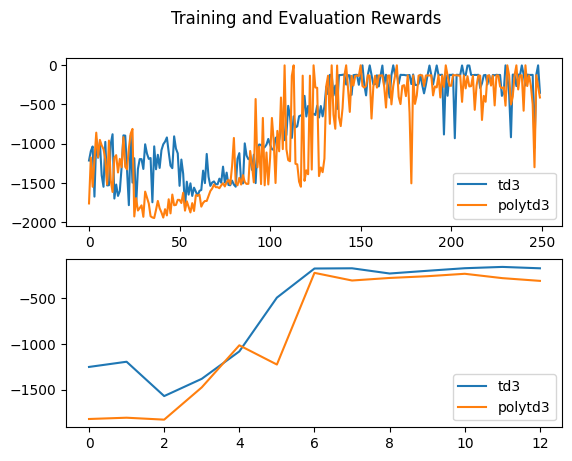

In [20]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2)
fig.suptitle('Training and Evaluation Rewards')
axs[0].plot(training_rewards_td3, label='td3')
axs[1].plot(eval_rewards_td3, label='td3')
axs[0].plot(training_rewards_polytd3, label='polytd3')
axs[1].plot(eval_rewards_polytd3, label='polytd3')
axs[0].legend(loc="lower right")
axs[1].legend(loc="lower right")

plt.savefig('figures/rewards.svg')